# Character-level recurrent sequence-to-sequence model
Author: [fchollet](https://twitter.com/fchollet)

Date created: 2017/09/29

Last modified: 2020/04/26

Description: Character-level recurrent sequence-to-sequence model.

Small additions by Pierre Nugues.

You will have to run and complete two notebooks. This is the first one.

## Introduction
This example demonstrates how to implement a basic character-level
recurrent sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
**Summary of the algorithm**
- We start with input sequences from a domain (e.g. English sentences)
    and corresponding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    It uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.

## Setup

In [1]:
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
random.seed(1234)
np.random.seed(1234)
#tf.keras.utils.set_random_seed(1234)
tf.random.set_seed(1234)

## Download the data

Have a look at the http://www.manythings.org/anki/ site and select a corpus with at least 10,000 pairs. You should understand the target language well. Ideally, it should be your mother tongue.
Then uncomment and run the lines below to download the dataset.

In [3]:
#!curl -O http://www.manythings.org/anki/swe-eng.zip
#!unzip swe-eng.zip

## Configuration

Run this notebook on Google Colab if you do not have a GPU. You will need then to mount the Google drive and configure the path. The cells below will help you.

You have to choose between a local execution on `my_machine` and `colab`

In [4]:
# The machine name
machine_name = 'my_machine' # or 'my_machine'

In [5]:
if machine_name == 'colab':
    from google.colab import drive
    drive.mount("/content/drive")

Adapt the path to your configuration

In [6]:
# Path to the data txt file on disk.
if machine_name == 'colab':
    data_path = '/content/drive/My Drive/Colab Notebooks/traduction LSTM/fra.txt'
else:
    data_path = 'swe.txt'

In [7]:
batch_size = 64  # Batch size for training.
epochs = 40  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.

## Prepare the data

Run the next cells to prepare the dataset. Be sure you understand all the code. I printed intermediate outputs to help you.

### Creating the pairs

In [8]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

In [9]:
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

In [10]:
input_texts[1000]

'I have a kid.'

In [11]:
target_texts[1000]

'\tJag har ett barn.\n'

### The input and output symbols

In [12]:
input_characters = sorted(list(input_characters))
print(input_characters)

[' ', '!', '"', "'", ',', '-', '.', '0', '1', '2', '5', '6', '7', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '€']


In [13]:
target_characters = sorted(list(target_characters))
print(target_characters)

['\t', '\n', ' ', '!', ',', '-', '.', '0', '1', '2', '5', '6', '7', '9', ':', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'Ä', 'Å', 'Ö', 'à', 'ä', 'å', 'é', 'ö', '”']


In [14]:
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [15]:
print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 66
Number of unique output tokens: 73
Max sequence length for inputs: 21
Max sequence length for outputs: 46


### Creating the indices

In [16]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

In [17]:
input_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 "'": 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '5': 10,
 '6': 11,
 '7': 12,
 '9': 13,
 ':': 14,
 '?': 15,
 'A': 16,
 'B': 17,
 'C': 18,
 'D': 19,
 'E': 20,
 'F': 21,
 'G': 22,
 'H': 23,
 'I': 24,
 'J': 25,
 'K': 26,
 'L': 27,
 'M': 28,
 'N': 29,
 'O': 30,
 'P': 31,
 'R': 32,
 'S': 33,
 'T': 34,
 'U': 35,
 'V': 36,
 'W': 37,
 'Y': 38,
 'a': 39,
 'b': 40,
 'c': 41,
 'd': 42,
 'e': 43,
 'f': 44,
 'g': 45,
 'h': 46,
 'i': 47,
 'j': 48,
 'k': 49,
 'l': 50,
 'm': 51,
 'n': 52,
 'o': 53,
 'p': 54,
 'q': 55,
 'r': 56,
 's': 57,
 't': 58,
 'u': 59,
 'v': 60,
 'w': 61,
 'x': 62,
 'y': 63,
 'z': 64,
 '€': 65}

In [18]:
target_token_index

{'\t': 0,
 '\n': 1,
 ' ': 2,
 '!': 3,
 ',': 4,
 '-': 5,
 '.': 6,
 '0': 7,
 '1': 8,
 '2': 9,
 '5': 10,
 '6': 11,
 '7': 12,
 '9': 13,
 ':': 14,
 '?': 15,
 'A': 16,
 'B': 17,
 'C': 18,
 'D': 19,
 'E': 20,
 'F': 21,
 'G': 22,
 'H': 23,
 'I': 24,
 'J': 25,
 'K': 26,
 'L': 27,
 'M': 28,
 'N': 29,
 'O': 30,
 'P': 31,
 'R': 32,
 'S': 33,
 'T': 34,
 'U': 35,
 'V': 36,
 'W': 37,
 'a': 38,
 'b': 39,
 'c': 40,
 'd': 41,
 'e': 42,
 'f': 43,
 'g': 44,
 'h': 45,
 'i': 46,
 'j': 47,
 'k': 48,
 'l': 49,
 'm': 50,
 'n': 51,
 'o': 52,
 'p': 53,
 'q': 54,
 'r': 55,
 's': 56,
 't': 57,
 'u': 58,
 'v': 59,
 'w': 60,
 'x': 61,
 'y': 62,
 'z': 63,
 'Ä': 64,
 'Å': 65,
 'Ö': 66,
 'à': 67,
 'ä': 68,
 'å': 69,
 'é': 70,
 'ö': 71,
 '”': 72}

### Vectorizing
We use one-hot encoding

In [19]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [20]:
input_texts[0]

'Go.'

In [21]:
target_texts[0]

'\tGå.\n'

Be sure to undesrtand how the arrays `decoder_input_data` and `decoder_target_data` are structured. In your report, you will explain it. You will give an example.

In [22]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

### Understanding the vectorization

In [23]:
encoder_input_data[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [24]:
input_token_index['G']

22

In [25]:
encoder_input_data[0][:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0

In [26]:
decoder_input_data[0]

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [27]:
target_token_index['V']

36

In [28]:
decoder_input_data[0][:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.],
 

In [29]:
decoder_target_data[0][:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
 

## Build the model

In [30]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens), name='encoder_input')
encoder = keras.layers.LSTM(latent_dim, return_state=True, name='encoder_lstm')
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

In [31]:
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

In [32]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens), name='decoder_input')

In [33]:
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm', dropout=0, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax", name='decoder_dense')
decoder_outputs = decoder_dense(decoder_outputs)

In [34]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Train the model

In [35]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 330752      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  337920      decoder_input[0][0]              
                                                                 encoder_lstm[0][1]           

In [37]:
callback_list = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
    keras.callbacks.ModelCheckpoint(filepath='initial.keras', monitor='val_loss', save_best_only=True)
]

In [38]:
history = model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    callbacks=callback_list
)

Train on 8000 samples, validate on 2000 samples
Epoch 1/40
8000/8000 [==============================] - 43s 5ms/sample - loss: 1.4474 - accuracy: 0.6514 - val_loss: 1.5890 - val_accuracy: 0.5975
Epoch 2/40
8000/8000 [==============================] - 39s 5ms/sample - loss: 1.0793 - accuracy: 0.7070 - val_loss: 1.1745 - val_accuracy: 0.6659
Epoch 3/40
8000/8000 [==============================] - 38s 5ms/sample - loss: 0.8886 - accuracy: 0.7480 - val_loss: 1.0262 - val_accuracy: 0.6997
Epoch 4/40
8000/8000 [==============================] - 40s 5ms/sample - loss: 0.7974 - accuracy: 0.7688 - val_loss: 0.9665 - val_accuracy: 0.7133
Epoch 5/40
8000/8000 [==============================] - 37s 5ms/sample - loss: 0.7445 - accuracy: 0.7829 - val_loss: 0.9116 - val_accuracy: 0.7272
Epoch 6/40
8000/8000 [==============================] - 37s 5ms/sample - loss: 0.7061 - accuracy: 0.7940 - val_loss: 0.8679 - val_accuracy: 0.7453
Epoch 7/40
8000/8000 [==============================] - 38s 5ms/sample

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

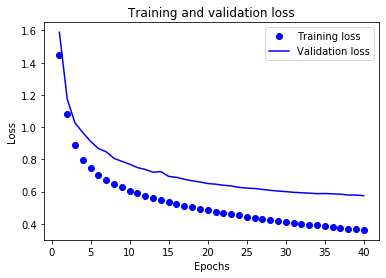

In [40]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

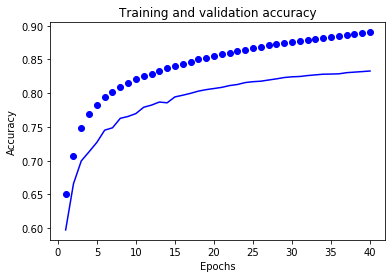

In [41]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [42]:
# Save model
#model.save('initial.keras')

## Run inference (sampling)
1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states

In [43]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
#model = keras.models.load_model('initial.keras')

In [44]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None, 66)]   0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 256), (None, 330752      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 256),  337920      decoder_input[0][0]              
                                                                 encoder_lstm[0][1]           

In [45]:
model.layers

In [46]:
[model_layer.name for model_layer in model.layers]

['encoder_input',
 'decoder_input',
 'encoder_lstm',
 'decoder_lstm',
 'decoder_dense']

In [47]:
model.input

[<tf.Tensor 'encoder_input:0' shape=(None, None, 66) dtype=float32>,
 <tf.Tensor 'decoder_input:0' shape=(None, None, 73) dtype=float32>]

In [48]:
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

In [49]:
decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

In [50]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [51]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=False)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence


You can now generate decoded sentences as such:

In [52]:
for seq_index in range(20):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    print("Input sentence:", input_texts[seq_index])
    print("Decoded sentence:", decoded_sentence)

-
Input sentence: Go.
Decoded sentence: Gå inte.

-
Input sentence: Run!
Decoded sentence: Stanna kvar!

-
Input sentence: Who?
Decoded sentence: Vem har han?

-
Input sentence: Help!
Decoded sentence: Skynda dig!

-
Input sentence: Jump!
Decoded sentence: Var inte!

-
Input sentence: Jump.
Decoded sentence: Ska vi bil.

-
Input sentence: Stop!
Decoded sentence: Stanna kvar!

-
Input sentence: Wait!
Decoded sentence: Var inte!

-
Input sentence: Wait.
Decoded sentence: Vänta mig.

-
Input sentence: Hurry!
Decoded sentence: Skynda dig!

-
Input sentence: Hurry!
Decoded sentence: Skynda dig!

-
Input sentence: Hurry!
Decoded sentence: Skynda dig!

-
Input sentence: I ran.
Decoded sentence: Jag är skyldig.

-
Input sentence: I see.
Decoded sentence: Jag ser skada.

-
Input sentence: I see.
Decoded sentence: Jag ser skada.

-
Input sentence: I won!
Decoded sentence: Jag vill ha det.

-
Input sentence: Relax.
Decoded sentence: Säg: ”är du gå.

-
Input sentence: Smile.
Decoded sentence: Se d

Write a `translate()` function that takes a string as argument and returns its translation 

In [53]:
# Write your code here
def translate(input_text):
    input_data = np.zeros(
        (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32"
    )
    for t, char in enumerate(input_text):
        input_data[0, t, input_token_index[char]] = 1.0
    input_data[0, t + 1 :, input_token_index[" "]] = 1.0
    return decode_sequence(input_data)

In [54]:
translation = translate('I am big!')
print(translation)

Jag är skyldig.



## Experiments

Once you have run all the cells, modify the LSTMs in the encoder and the decoder to introduce a dropout and a recurrent dropout. Read the documentation here: https://keras.io/api/layers/recurrent_layers/lstm/

You will try at least two sets of parameters per network. In your report, you will present your results in a table like this one:

|Method|Dropout|Reccurent Dropout|Accuracy|Loss|Val Accuracy|Val Loss|
|------|-----|-----|-----|-----|-----|-----|
|LSTM |0.2 |0 |0.8714 | 0.4303 | 0.8142 | 0.6425 |
|LSTM |0  |0.2 |0.8903 | 0.3625 | 0.8329 | 0.5750 |
|2LSTM|0.2|0.2 | 0.8539| 0.4895| 0.8185 | 0.6164
